### Main Notebook for visualisation 

Setup for required libraries:

In [46]:
%pip install numpy pandas matplotlib keras scikit-learn tensorflow networkx stellargraph chardet torch torchvision torchaudio torch_geometric visualkeras

Note: you may need to restart the kernel to use updated packages.


Importing data for DNN training (using Pandas):

In [47]:
import pandas as pd
import numpy as np

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'
# file_path = 'dtap/grid/4_agents/4/velocity_metrics.csv'
# file_path2 = 'dtap/grid/4_agents/4/idleness.csv'
# file_path3 = 'dtap/grid/4_agents/4/vulnerabilities.csv'
# file_path4 = 'dtap/grid/4_agents/4/distance_metrics.csv'
# file_path = 'cbls/grid/4_agents/4/velocity_metrics.csv'
# file_path2 = 'cbls/grid/4_agents/4/idleness.csv'
# file_path3 = 'cbls/grid/4_agents/4/vulnerabilities.csv'
# file_path4 = 'cbls/grid/4_agents/4/distance_metrics.csv'
# file_path = 'dtag/grid/4_agents/3/velocity_metrics.csv'
# file_path2 = 'dtag/grid/4_agents/3/idleness.csv'
# file_path3 = 'dtag/grid/4_agents/3/vulnerabilities.csv'
# file_path4 = 'dtag/grid/4_agents/3/distance_metrics.csv'


df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)



In [48]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, LSTM, Reshape
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.random.set_seed(7)

Creating data for graph layout using Networkx:

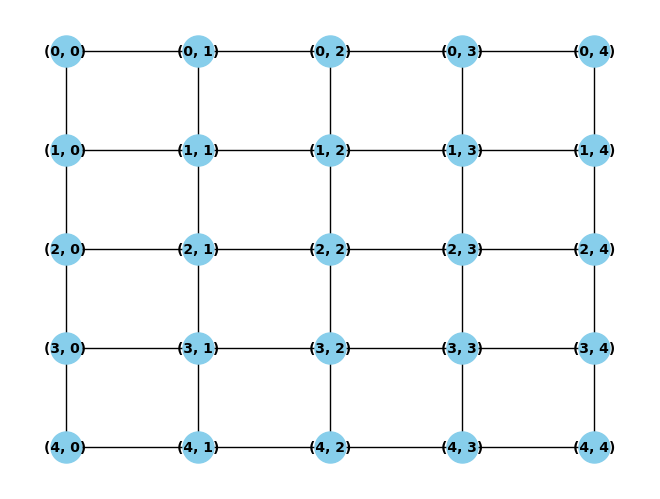

(25, 25)

In [49]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a 5x5 grid graph
G = nx.grid_2d_graph(5, 5)

# Plot the graph
pos = {(x, y): (y, -x) for x, y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', font_weight='bold')

plt.axis('off')
plt.show()

adjacency_matrix = nx.adjacency_matrix(G)
adjacency_matrix = adjacency_matrix.toarray()
adjacency_matrix.shape

For all nodes:

In [50]:
N = len(df_vel.T)-1

vel_data = df_vel.iloc[:, 1:N+1]
idle_data = df_idle.iloc[:, 1:N+1]
idle_data[idle_data < 0] = np.nan

vuln_data = df_vuln.iloc[:, 1:N+1]
dist_data = df_dist.iloc[:, 1:N+1]

df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
df = df.dropna()

threshold = 50

for col in range(N*3,N*4):

    df.iloc[df.iloc[:, col] < threshold, col] = 0
    df.iloc[df.iloc[:, col] >= threshold, col] = 1
df.iloc[:,75:100]



/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_28088/3979858448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle_data[idle_data < 0] = np.nan
/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_28088/3979858448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle_data[idle_data < 0] = np.nan


,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
154,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
155,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
156,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
157,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
158,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21391,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21392,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


Train and test split:

In [51]:
dataset = df.to_numpy()
# dataset[2] = scaler.fit_transform(dataset[2])


# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
df.iloc[:,75:100].value_counts()
# df.iloc[:,75:100]
# df.iloc[:,50:75]

dataset.shape
train.shape



14869 6373


(14869, 100)

In [52]:
def create_dataset(dataset, look_back=1):
	dataX, dataY, node_metrics = [], [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:-N]
		dataX.append(a)
		dataY.append(dataset[i + look_back, N*3:N*4])
		node_metrics.append(dataset[i + look_back, 0:-N])
	return np.array(dataX), np.array(dataY), np.array(node_metrics)

look_back = 50

trainX, trainY, node_metrics_train = create_dataset(train, look_back)
testX, testY, node_metrics_test = create_dataset(test, look_back)
print(trainX.shape)
print(trainY.shape)

print(node_metrics_test.shape)


(14818, 50, 75)
(14818, 25)
(6322, 75)


In [53]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[-1]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[-1]))
node_metrics_train = np.reshape(node_metrics_train, (node_metrics_train.shape[0],node_metrics_train.shape[-1]//3,3))
node_metrics_test = np.reshape(node_metrics_test, (node_metrics_test.shape[0],node_metrics_test.shape[-1]//3,3))


adjacency_matrix_train = np.repeat(adjacency_matrix[np.newaxis, :, :], node_metrics_train.shape[0], axis=0)
adjacency_matrix_test = np.repeat(adjacency_matrix[np.newaxis, :, :], node_metrics_test.shape[0], axis=0)
adjacency_matrix_train.shape

(14818, 25, 25)

#### DNN with GCN

In [54]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Sequential()

model.add(LSTM(4, input_shape=(node_metrics_train.shape[1], node_metrics_train.shape[-1])))


model.add(Dense(25, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.fit(node_metrics_train, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
14818/14818 - 89s - loss: 0.4681 - accuracy: 0.0376 - 89s/epoch - 6ms/step
Epoch 2/10
14818/14818 - 78s - loss: 0.4519 - accuracy: 0.0497 - 78s/epoch - 5ms/step
Epoch 3/10
14818/14818 - 76s - loss: 0.4483 - accuracy: 0.0507 - 76s/epoch - 5ms/step
Epoch 4/10
14818/14818 - 73s - loss: 0.4463 - accuracy: 0.0476 - 73s/epoch - 5ms/step
Epoch 5/10
14818/14818 - 72s - loss: 0.4446 - accuracy: 0.0434 - 72s/epoch - 5ms/step
Epoch 6/10
14818/14818 - 73s - loss: 0.4430 - accuracy: 0.0420 - 73s/epoch - 5ms/step
Epoch 7/10
14818/14818 - 74s - loss: 0.4416 - accuracy: 0.0430 - 74s/epoch - 5ms/step
Epoch 8/10
14818/14818 - 73s - loss: 0.4410 - accuracy: 0.0404 - 73s/epoch - 5ms/step
Epoch 9/10
14818/14818 - 71s - loss: 0.4409 - accuracy: 0.0405 - 71s/epoch - 5ms/step
Epoch 10/10
14818/14818 - 73s - loss: 0.4405 - accuracy: 0.0406 - 73s/epoch - 5ms/step


In [55]:

trainPredict = model.predict(node_metrics_train, batch_size = 1)
testPredict = model.predict(node_metrics_test, batch_size = 1)

# trainPredict = model.predict(node_metrics_train)
# testPredict = model.predict(node_metrics_test)

print(trainPredict.max())
# Apply a threshold to convert the probabilities to binary predictions (0 or 1)
threshold = 0.5 # Adjust the threshold if needed
trainPredict_binary = (trainPredict > threshold).astype(int)
testPredict_binary = (testPredict > threshold).astype(int)


6322/6322 [==============================] - 13s 2ms/step
0.9692188


#### Accuracy Measures and counts of succesful, failed and missed attacks:

In [56]:
from sklearn.metrics import accuracy_score, f1_score

# Compute accuracy and F1 score

flattened_trainPredict_binary = trainPredict_binary.ravel()
flattened_testPredict_binary = testPredict_binary.ravel()

flattened_trainY = trainY.ravel()
flattened_testY = testY.ravel()

train_accuracy = accuracy_score(flattened_trainY, flattened_trainPredict_binary)
test_accuracy = accuracy_score(flattened_testY, flattened_testPredict_binary)

train_f1_score = f1_score(flattened_trainY, flattened_trainPredict_binary)
test_f1_score = f1_score(flattened_testY, flattened_testPredict_binary)

print('Train Accuracy for average:', train_accuracy)
print('Test Accuracy for average:', test_accuracy)

print('Train F1 Score for average: ', train_f1_score)
print('Test F1 Score for average: ', test_f1_score)

Train Accuracy for average: 0.7866918612498313
Test Accuracy for average: 0.7865865232521354
Train F1 Score for average:  0.4516916928030198
Test F1 Score for average:  0.4437114490220008


In [57]:

all_train_actions = pd.DataFrame(flattened_trainPredict_binary)
check_all_train_actions = pd.concat([all_train_actions,pd.DataFrame(flattened_trainY)],axis=1)
all_test_actions = pd.DataFrame(flattened_testPredict_binary)
check_all_test_actions = pd.concat([all_test_actions,pd.DataFrame(flattened_testY)],axis=1)


train_attacks = check_all_train_actions[check_all_train_actions.iloc[:,0] == 1]
train_no_actions = check_all_train_actions[check_all_train_actions.iloc[:,0] == 0]
test_attacks = check_all_test_actions[check_all_test_actions.iloc[:,0] == 1]
test_no_actions = check_all_test_actions[check_all_test_actions.iloc[:,0] == 0]


train_success =  ((train_attacks.iloc[:,1]==1) == True).sum()
train_failed = len(train_attacks)-train_success
train_missed = ((train_no_actions.iloc[:,1]==1) == True).sum()
test_success =  ((test_attacks.iloc[:,1]==1) == True).sum()
test_failed = len(test_attacks)-test_success
test_missed = ((test_no_actions.iloc[:,1]==1) == True).sum()


print('\nFor Training: ')
print('- Number of succesful attacks:', train_success)
print('- Number of failed attacks:', train_failed)
print('- Number of missed attacks:', train_missed)

print('\nFor Testing: ')
print('- Number of succesful attacks:', test_success)
print('- Number of failed attacks:', test_failed)
print('- Number of missed attacks:', test_missed)




For Training: 
- Number of succesful attacks: 32548
- Number of failed attacks: 17302
- Number of missed attacks: 61718

For Testing: 
- Number of succesful attacks: 13452
- Number of failed attacks: 7580
- Number of missed attacks: 26150


#### Checks for each node individually:

In [58]:
for node in range(0,N-1):
    train_accuracy = accuracy_score(trainY[:,node], trainPredict_binary[:,node])
    test_accuracy = accuracy_score(testY[:,node], testPredict_binary[:,node])

    train_f1_score = f1_score(trainY[:,node], trainPredict_binary[:,node])
    test_f1_score = f1_score(testY[:,node], testPredict_binary[:,node])

    print('\n\nnode: ', node+1)

    print('\nTrain Accuracy for node:', node+1, 'is:' ,train_accuracy)
    print('Test Accuracy for node:', node+1, 'is:' ,test_accuracy)

    print('\nTrain F1 Score for node: ', node+1, 'is:', train_f1_score)
    print('Test F1 Score for node: ', node+1, 'is:', test_f1_score)



node:  1

Train Accuracy for node: 1 is: 0.951950330678904
Test Accuracy for node: 1 is: 0.9550775071180007

Train F1 Score for node:  1 is: 0.0
Test F1 Score for node:  1 is: 0.0


node:  2

Train Accuracy for node: 2 is: 0.982116344985828
Test Accuracy for node: 2 is: 0.9844985763998735

Train F1 Score for node:  2 is: 0.0
Test F1 Score for node:  2 is: 0.0


node:  3

Train Accuracy for node: 3 is: 0.6378053718450533
Test Accuracy for node: 3 is: 0.6564378361278077

Train F1 Score for node:  3 is: 0.27794968384232477
Test F1 Score for node:  3 is: 0.2571819425444596


node:  4

Train Accuracy for node: 4 is: 0.5791604804966932
Test Accuracy for node: 4 is: 0.5760835178740905

Train F1 Score for node:  4 is: 0.5426811381636845
Test F1 Score for node:  4 is: 0.5164200649584987


node:  5

Train Accuracy for node: 5 is: 0.5554730732892428
Test Accuracy for node: 5 is: 0.5517241379310345

Train F1 Score for node:  5 is: 0.6026901501899995
Test F1 Score for node:  5 is: 0.5890371229698

In [59]:
for node in range(0,N-1):
    train_actions = pd.DataFrame(trainPredict_binary[:,node])
    check_train_actions = pd.concat([train_actions,pd.DataFrame(trainY[:,node])],axis=1)
    test_actions = pd.DataFrame(testPredict_binary[:,node])
    check_test_actions = pd.concat([test_actions,pd.DataFrame(testY[:,node])],axis=1)


    train_attacks = check_train_actions[check_train_actions.iloc[:,0] == 1]
    train_no_actions = check_train_actions[check_train_actions.iloc[:,0] == 0]
    test_attacks = check_test_actions[check_test_actions.iloc[:,0] == 1]
    test_no_actions = check_test_actions[check_test_actions.iloc[:,0] == 0]


    train_success =  ((train_attacks.iloc[:,1]==1) == True).sum()
    train_failed = len(train_attacks)-train_success
    train_missed = ((train_no_actions.iloc[:,1]==1) == True).sum()
    test_success =  ((test_attacks.iloc[:,1]==1) == True).sum()
    test_failed = len(test_attacks)-test_success
    test_missed = ((test_no_actions.iloc[:,1]==1) == True).sum()


    print('\n\nNode: ', node+1)
    print('\nFor Training: ')
    print('- Number of succesful attacks:', train_success)
    print('- Number of failed attacks:', train_failed)
    print('- Number of missed attacks:', train_missed)

    print('For Testing: ')
    print('- Number of succesful attacks:', test_success)
    print('- Number of failed attacks:', test_failed)
    print('- Number of missed attacks:', test_missed)



Node:  1

For Training: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 712
For Testing: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 284


Node:  2

For Training: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 265
For Testing: 
- Number of succesful attacks: 0
- Number of failed attacks: 0
- Number of missed attacks: 98


Node:  3

For Training: 
- Number of succesful attacks: 1033
- Number of failed attacks: 987
- Number of missed attacks: 4380
For Testing: 
- Number of succesful attacks: 376
- Number of failed attacks: 374
- Number of missed attacks: 1798


Node:  4

For Training: 
- Number of succesful attacks: 3700
- Number of failed attacks: 3043
- Number of missed attacks: 3193
For Testing: 
- Number of succesful attacks: 1431
- Number of failed attacks: 1294
- Number of missed attacks: 1386


Node:  5

For Training: 
- Number of succesful att

#### Graph of successful vs failed attacks with varying binary threshold:

Also I know this doesnt adhear to DRY principles

/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_28088/4225081205.py:44: RuntimeWarning: invalid value encountered in scalar divide
  train_total_list.append(train_success/(train_success+train_failed)*100)
/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_28088/4225081205.py:47: RuntimeWarning: invalid value encountered in scalar divide
  test_total_list.append(test_success/(test_success+test_failed)*100)


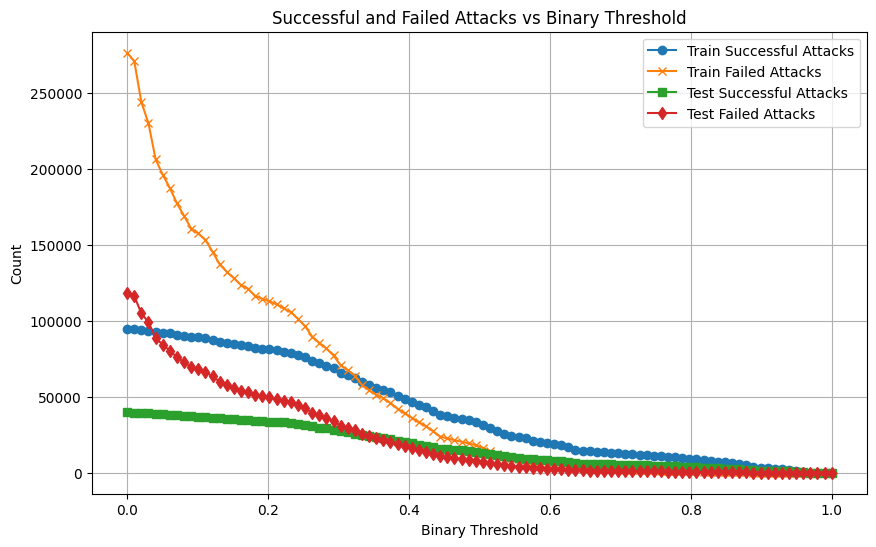

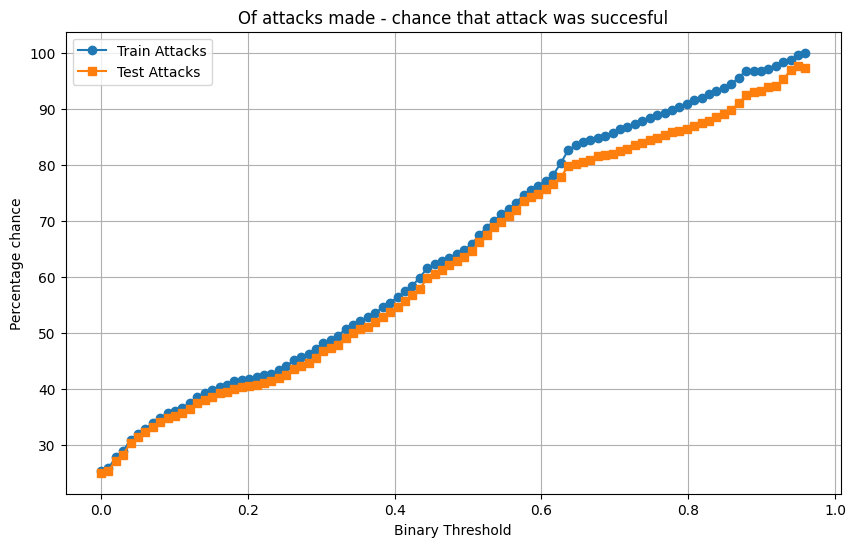

In [60]:
import matplotlib.pyplot as plt

thresholds = np.linspace(0,1,100)
train_success_list = []
train_failed_list = []
test_success_list = []
test_failed_list = []
train_total_list = []
test_total_list = []

for threshold in thresholds:
    # Apply a threshold to convert the probabilities to binary predictions (0 or 1)
    # threshold = 0.5 # Adjust the threshold if needed
    trainPredict_binary = (trainPredict > threshold).astype(int)
    testPredict_binary = (testPredict > threshold).astype(int)

    flattened_trainPredict_binary = trainPredict_binary.ravel()
    flattened_testPredict_binary = testPredict_binary.ravel()

    flattened_trainY = trainY.ravel()
    flattened_testY = testY.ravel()

    all_train_actions = pd.DataFrame(flattened_trainPredict_binary)
    check_all_train_actions = pd.concat([all_train_actions,pd.DataFrame(flattened_trainY)],axis=1)
    all_test_actions = pd.DataFrame(flattened_testPredict_binary)
    check_all_test_actions = pd.concat([all_test_actions,pd.DataFrame(flattened_testY)],axis=1)


    train_attacks = check_all_train_actions[check_all_train_actions.iloc[:,0] == 1]
    train_no_actions = check_all_train_actions[check_all_train_actions.iloc[:,0] == 0]
    test_attacks = check_all_test_actions[check_all_test_actions.iloc[:,0] == 1]
    test_no_actions = check_all_test_actions[check_all_test_actions.iloc[:,0] == 0]


    train_success =  ((train_attacks.iloc[:,1]==1) == True).sum()
    train_failed = len(train_attacks)-train_success
    train_missed = ((train_no_actions.iloc[:,1]==1) == True).sum()
    test_success =  ((test_attacks.iloc[:,1]==1) == True).sum()
    test_failed = len(test_attacks)-test_success
    test_missed = ((test_no_actions.iloc[:,1]==1) == True).sum()

    train_success_list.append(train_success)
    train_failed_list.append(train_failed)
    train_total_list.append(train_success/(train_success+train_failed)*100)
    test_success_list.append(test_success)
    test_failed_list.append(test_failed)
    test_total_list.append(test_success/(test_success+test_failed)*100)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_success_list, label='Train Successful Attacks', marker='o')
plt.plot(thresholds, train_failed_list, label='Train Failed Attacks', marker='x')
plt.plot(thresholds, test_success_list, label='Test Successful Attacks', marker='s')
plt.plot(thresholds, test_failed_list, label='Test Failed Attacks', marker='d')

plt.title('Successful and Failed Attacks vs Binary Threshold')
plt.xlabel('Binary Threshold')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
# plt.savefig("decay_learning_rate_0.001_success_fail.png")


plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_total_list, label='Train Attacks', marker='o')
plt.plot(thresholds, test_total_list, label='Test Attacks', marker='s')

plt.title('Of attacks made - chance that attack was succesful')
plt.xlabel('Binary Threshold')
plt.ylabel('Percentage chance')
plt.legend()
plt.grid(True)
# plt.savefig("decay_learning_rate_0.001_%_chance.png")
plt.show()



#### Graphs for another form of visualisation (blue is actual opportunity to attack, red is adversary actions):

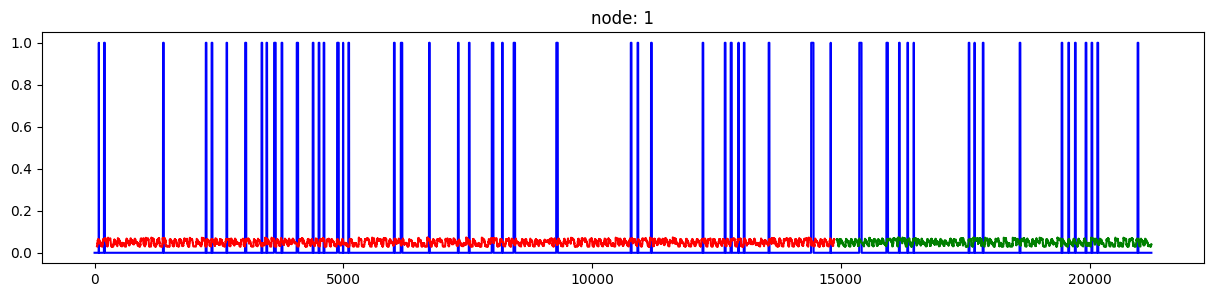

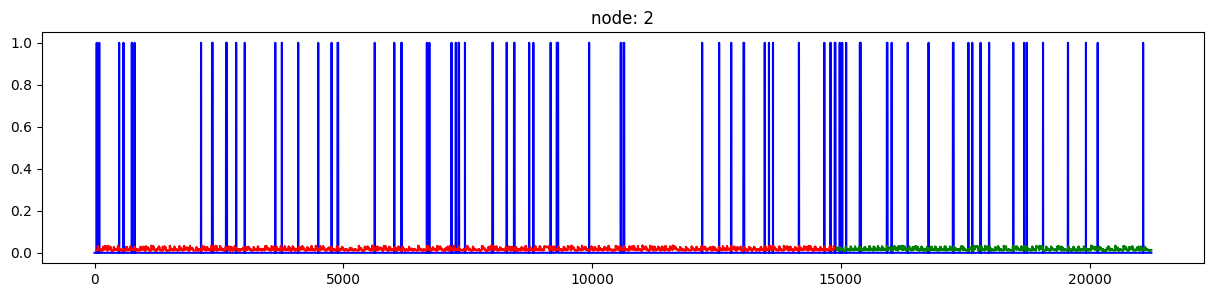

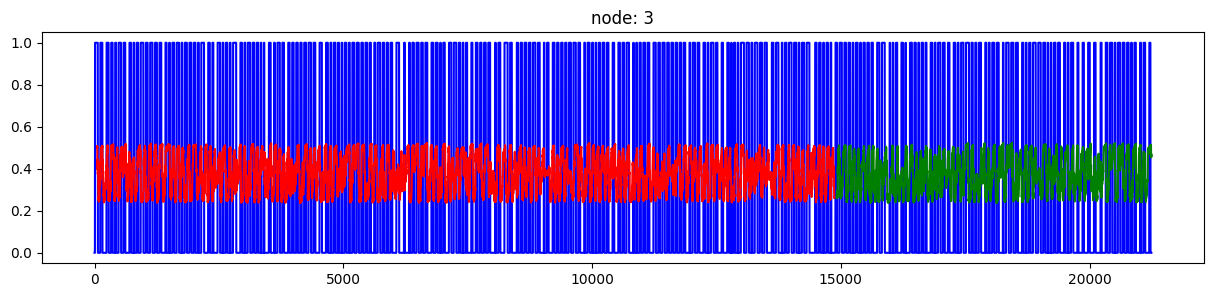

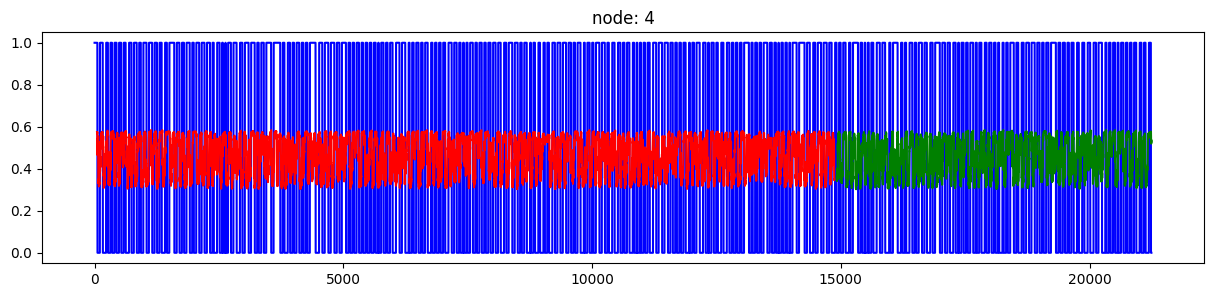

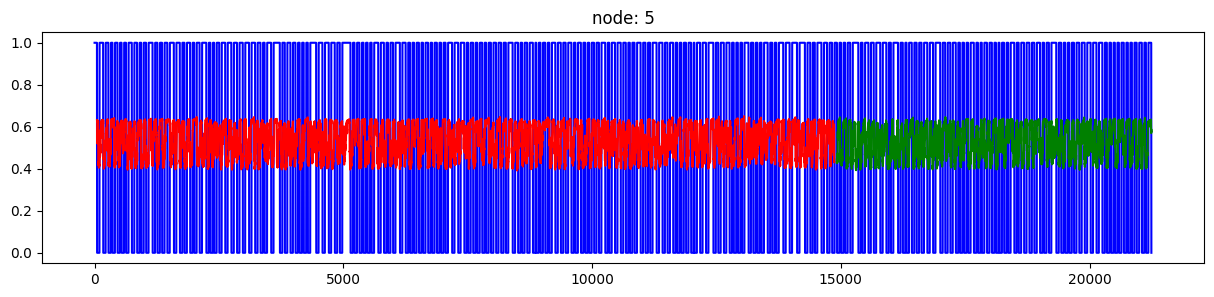

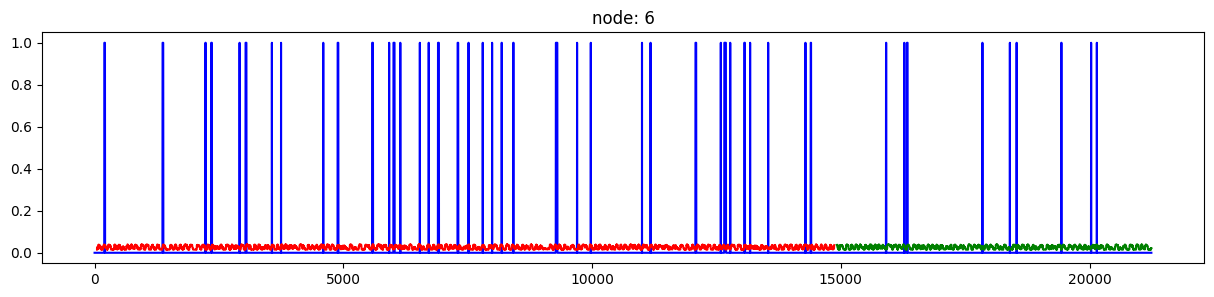

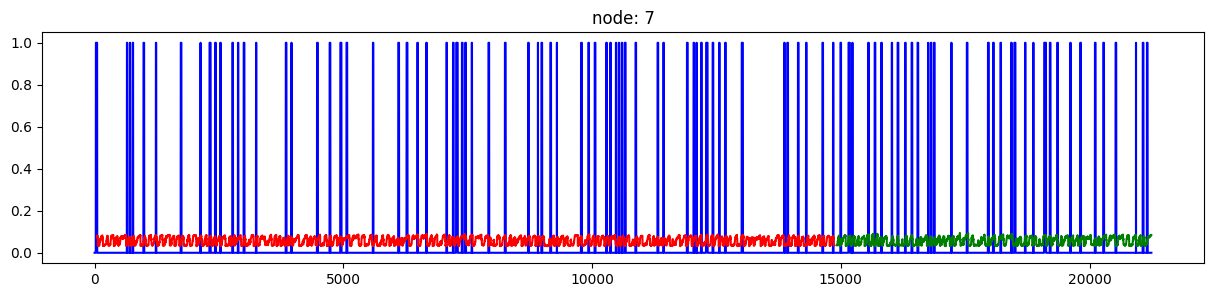

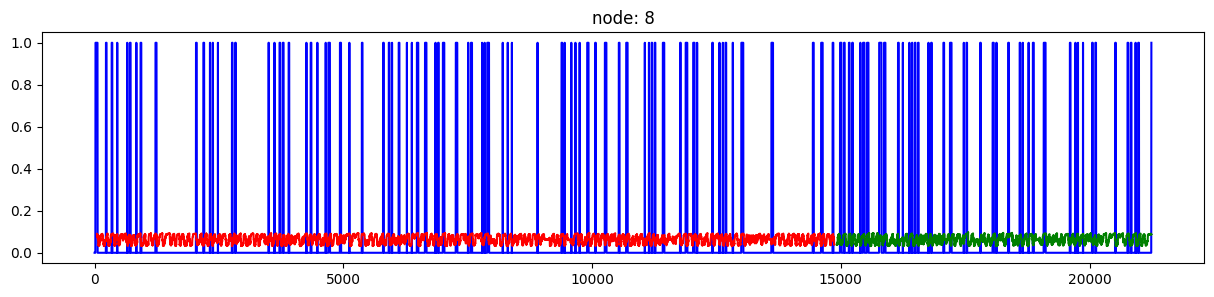

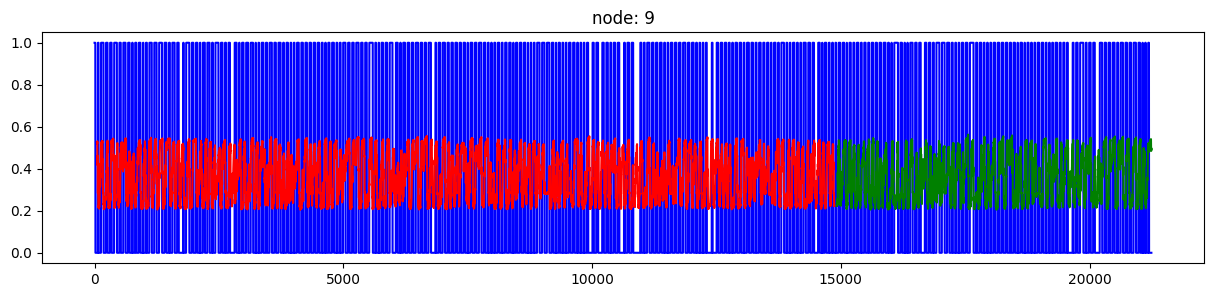

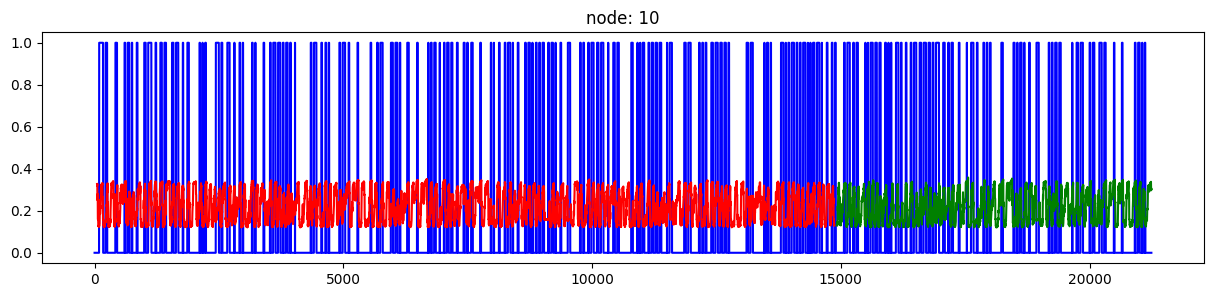

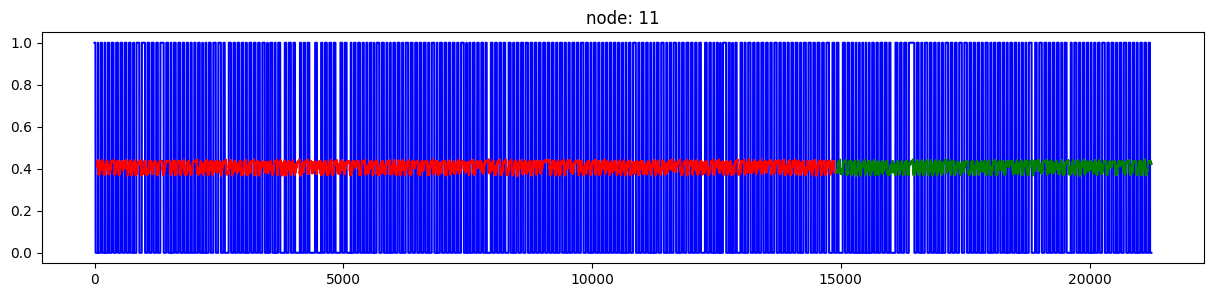

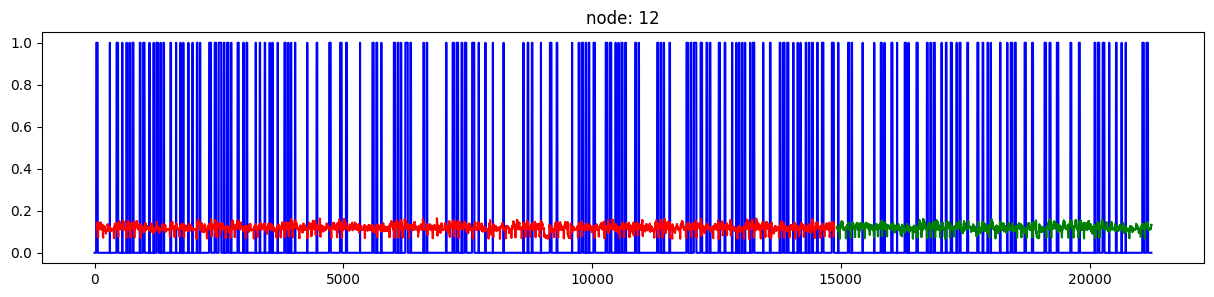

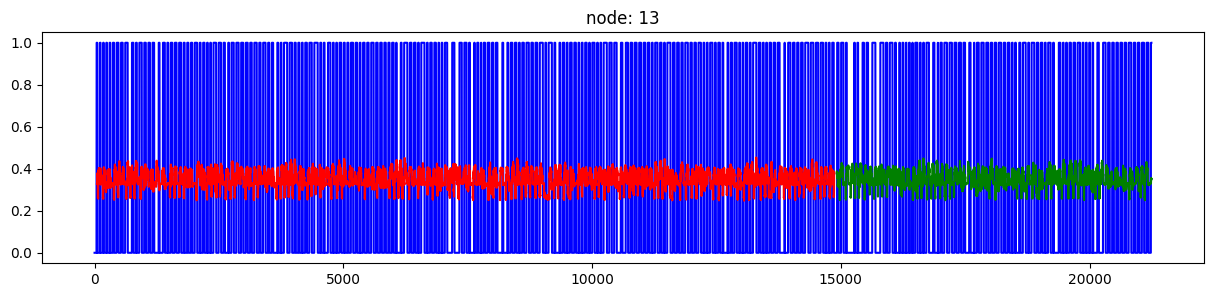

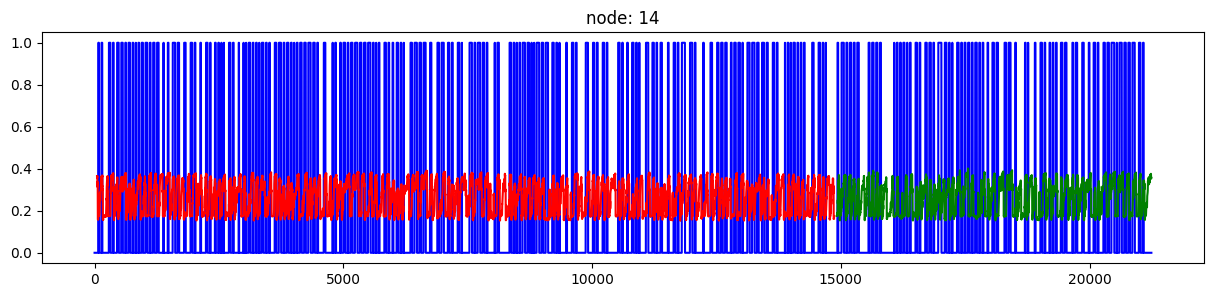

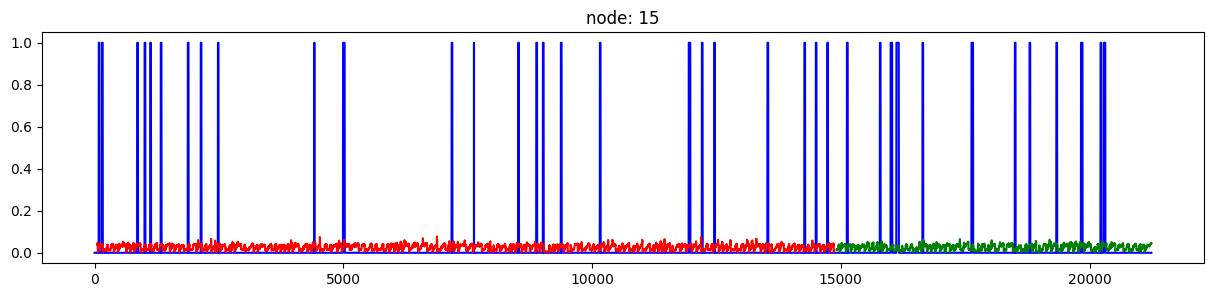

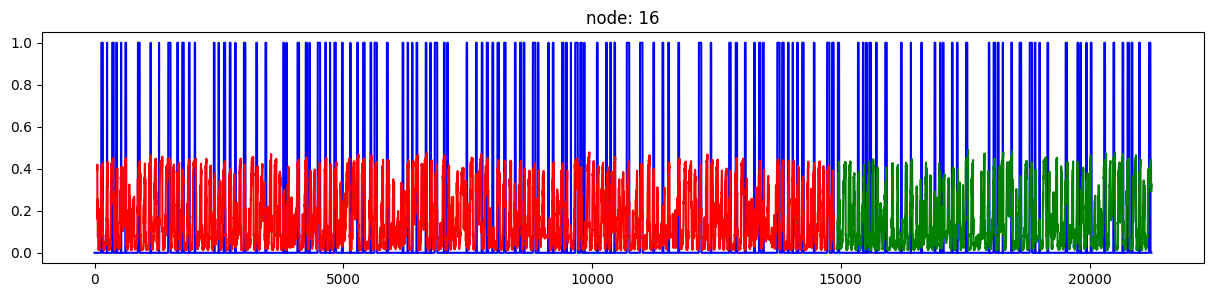

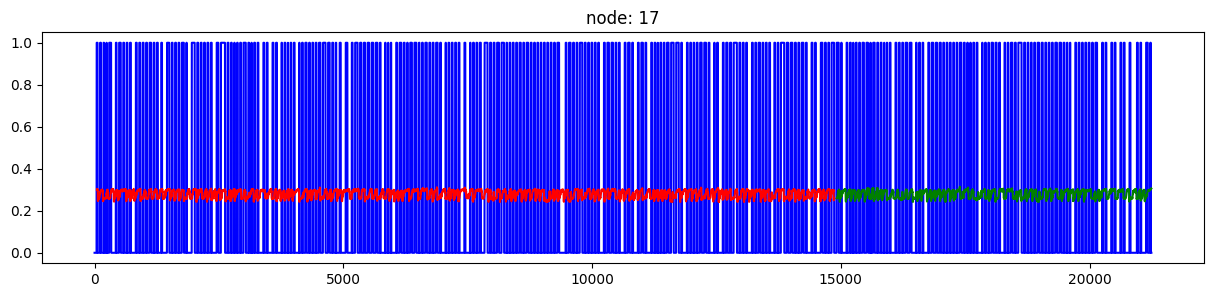

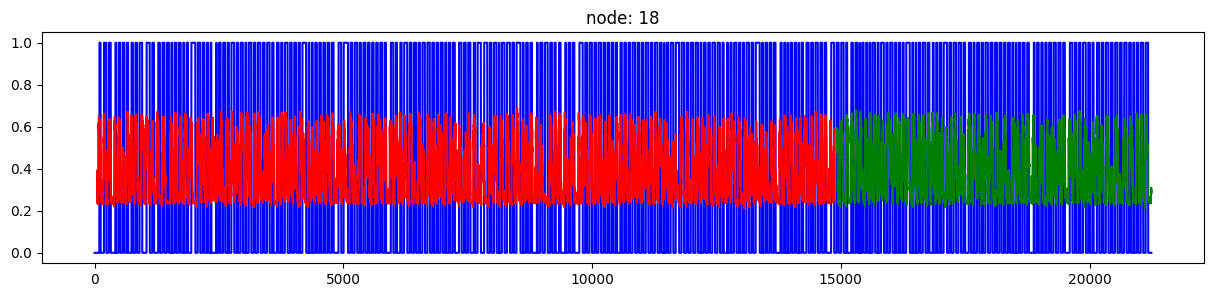

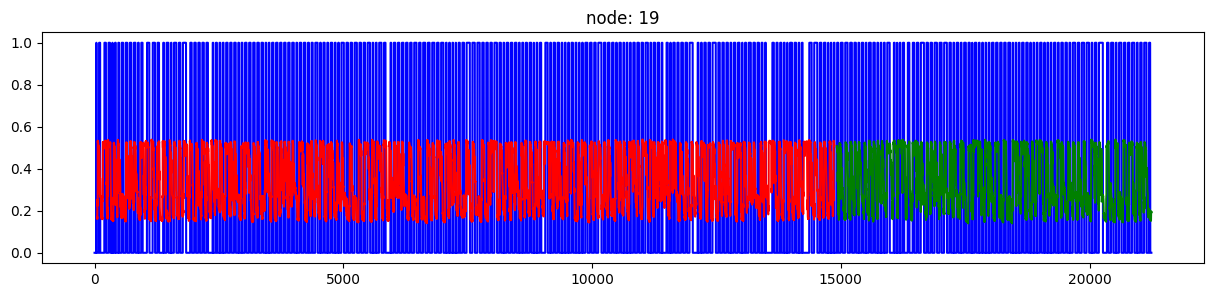

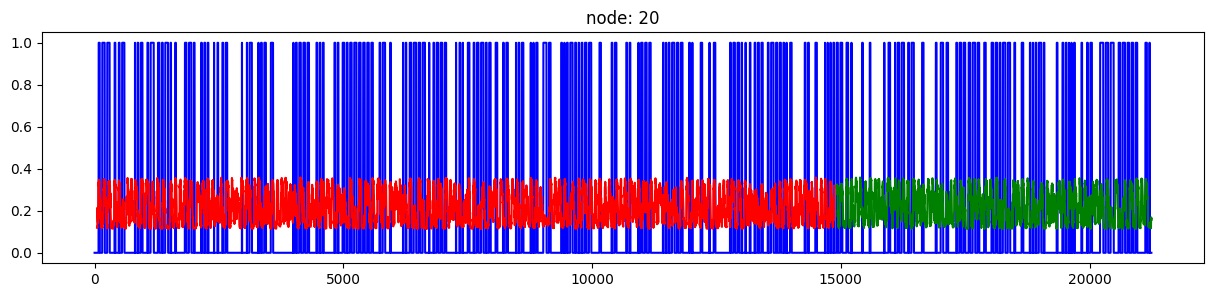

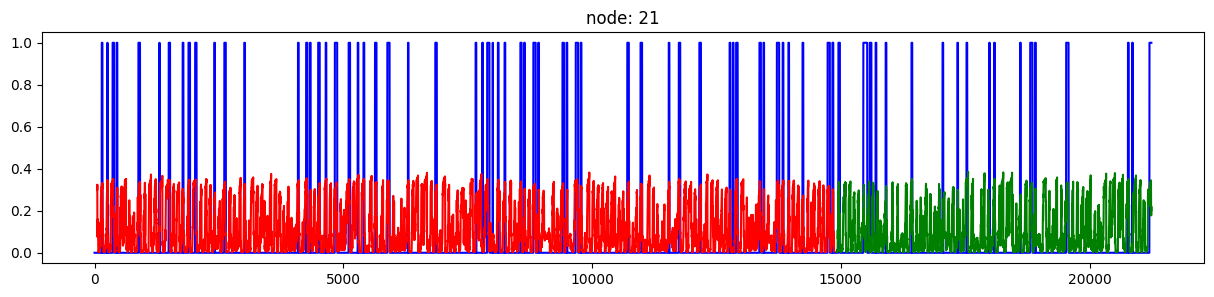

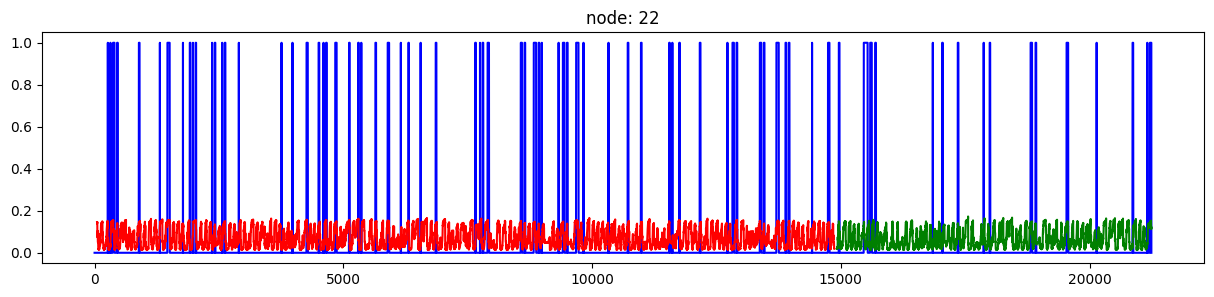

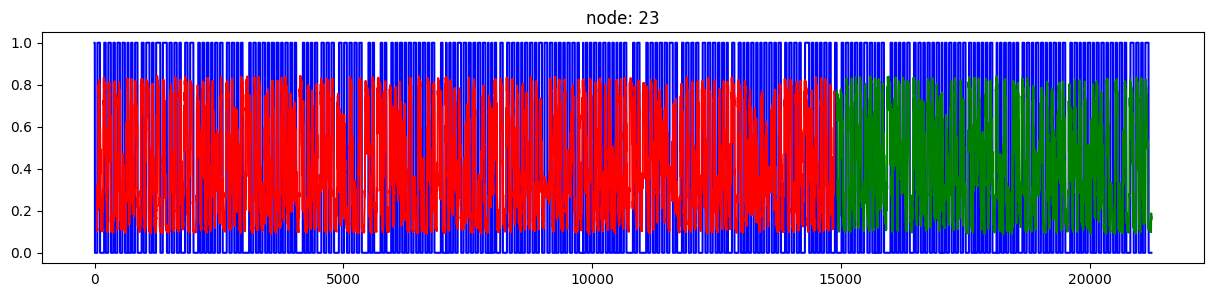

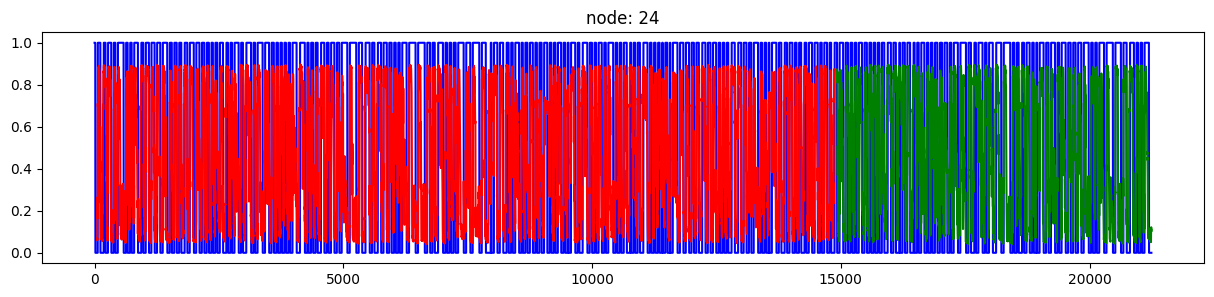

In [61]:


# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,N*3:N*4])
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back,:] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,N*3:N*4])
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+look_back*2+1:len(dataset[:,N*3:N*4])-1,:] = testPredict
# plot baseline and predictions
for col in range(0,N-1):
    plt.figure(figsize=(15, 3))
    plt.title('node: ' + str(col+1))
    plt.plot(dataset[:,N*3+col],'b')
    plt.plot(trainPredictPlot[:,col],'r')
    plt.plot(testPredictPlot[:,col],'g')
    # plt.savefig('node: ' + str(col+1) + ' sigmoid_output.png') 
    plt.show()

In [62]:
print(look_back)

50
